# Analysis of Jiu-Jitsu Competition Data


In [470]:
# Importing necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy.stats import chi2_contingency


# Setting display options for better readability
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)


## Dataset Description

This dataset is derived from a GitHub project that scrapes data from the Brazilian Jiu-Jitsu (BJJ) Heroes website. The project's repository can be found at [https://github.com/bjagrelli/bjj_data_scrapping](https://github.com/bjagrelli/bjj_data_scrapping). The dataset contains detailed information about BJJ matches and fighters.

### Columns:

- **ID**: Unique identifier for each record.
- **First Name**: Fighter's first name.
- **Last Name**: Fighter's last name.
- **Nickname**: Fighter's nickname.
- **Team**: Fighter's team or club.
- **Id**: Unique ID for the fighter.
- **Opponent**: Name of the fighter's opponent.
- **W/L**: Win or Loss status for the fighter.
- **Method**: Method of victory or defeat.
- **Competition**: Name of the BJJ competition.
- **Weight**: Weight category of the match.
- **Stage**: Stage of the competition (e.g., final, semifinal).
- **Year**: Year of the match.
- **Full Name**: Full name of the fighter.
- **Win**: Binary indicator of win (1) or loss (0).
- **Win_Streak**: Number of consecutive wins up to that match.

### Purpose:

The dataset is intended for analysis of BJJ match outcomes, fighters' performance, and competition trends. It is suitable for statistical analysis, pattern recognition, and historical data review in the context of martial arts research.


### Data Cleaning

### Initial Data State
The initial dataset obtained from the web scraping of the BJJ Heroes website was structured in a limited and condensed format. Specifically, the data was split into only 5 columns, making it difficult to analyze and extract meaningful insights directly. The columns were not distinctly separated, with multiple pieces of information combined in single columns.

### Transformation Process
To make the dataset more suitable for analysis, the following transformation steps were taken:

1. **Splitting Combined Data**: Data in single columns was split into multiple columns for better clarity and structure.
2. **Renaming Columns**: Columns were renamed to accurately represent the data they contained.
3. **Handling Missing Data**: Where applicable, missing data was identified and handled appropriately.

The Python code used for this transformation is provided below:


In [471]:
# Re-load the new data
data_new = pd.read_csv("data_new_sep.csv")

In [472]:
# Correct the column names first, assuming the first column is 'Link' which needs to be removed
data_new.columns = ['Link', 'Name', 'Sub', 'Unused1', 'Unused2']

In [473]:
# Dropping the 'Link' column from the DataFrame
data_new.drop('Link', axis=1, inplace=True)

In [474]:
# Splitting 'Name' column
split_name = data_new['Name'].str.split('|', expand=True)
data_new['First Name'] = split_name[0]
data_new['Last Name'] = split_name[1]
data_new['Nickname'] = split_name[2]
data_new['Team'] = split_name[3]

In [475]:
# Splitting 'Sub' column
split_sub = data_new['Sub'].str.split("|", expand=True)
data_new[['Id', 'Opponent', 'W/L', 'Method', 'Competition', 'Weight', 'Stage', 'Year']] = split_sub

In [476]:
def parse_method(method):
    if pd.isna(method):
        return method, None, None

    # Initial values for points and advantage
    points, advantage = None, None

    # Handling cases where 'Pts:' or 'Adv' is in the method
    if 'Pts:' in method:
        method_parts = method.split('Pts:', 1)
        method = 'Points'
        points_part = method_parts[1].strip()

        if ', Adv' in points_part:
            points, advantage = points_part.split(', ', 1)
        else:
            points = points_part

    elif method.strip() == 'Adv':
        method = 'Advantage'
        advantage = 'Adv'

    # Handling other methods
    else:
        method = method.strip()
        if method == 'Points':
            method = 'Points'
            points = 'Points'
        elif method == 'Adv':
            method = 'Advantage'
            advantage = 'Advantage'

    return method, points, advantage

In [477]:
# Apply the function to each row and create new columns
data_new[['Method', 'Points', 'Advantage']] = data_new.apply(lambda row: pd.Series(parse_method(row['Method'])), axis=1)

In [478]:
# Dropping unused columns
data_new.drop(columns=['Name', 'Sub', 'Unused1', 'Unused2'], inplace=True)

In [479]:
# Move the 'Id' column to the first position
cols = ['Id'] + [col for col in data_new if col != 'Id']
data_new = data_new[cols]

In [480]:
# Display the processed data
data_new.head()

,Id,First Name,Last Name,Nickname,Team,Opponent,W/L,Method,Competition,Weight,Stage,Year,Points,Advantage
0,NaN,"['Aarae', 'Alexander', '', 'Team Lloyd Irvin']",None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7672,Aaron,Johnson,Tex,Unity JJ,Quentin Rosensweig,L,Inside heel hook,Kakuto 5,ABS,SPF,2015,None,None
2,8190,Aaron,Johnson,Tex,Unity JJ,Neiman Gracie,L,RNC,NoGi Pan Ams,94KG,SF,2015,None,None
3,8785,Aaron,Johnson,Tex,Unity JJ,Richie MartinezRichie Martinez,L,Heel hook,Kakuto Challenge,ABS,SF,2015,None,None
4,9059,Aaron,Johnson,Tex,Unity JJ,Leo NogueiraLeo Nogueira,L,Points,Atlanta W. Open,94KG,SF,2016,Points,None


#### Parsing Match Outcome Methods

The `parse_method` function is employed to parse the 'Method' column, which describes the outcome of a Brazilian Jiu-Jitsu match. This function is responsible for extracting and segregating the data into two new columns: 'Points' and 'Advantage'. Here's the detailed logic of the function:

1. **Missing Values**: If the 'Method' entry is missing (NaN), both 'Points' and 'Advantage' are assigned `None`.

2. **Detailed Points Victory**: If the 'Method' includes 'Pts:' with details (e.g., "Pts: 2x0"), this denotes a victory by a specific point difference. The function extracts this detailed score into the 'Points' column.

   - When ', Adv' follows the point details (e.g., "Pts: 2x2, Adv"), it indicates a victory by advantage despite a tied score. The function parses the score into the 'Points' column and 'Adv' into the 'Advantage' column.

3. **Victory by Advantage with No Specific Points**: If 'Method' is just 'Adv', it indicates a win by advantage where the exact points are not provided. Here, 'Points' remains `None` as no specific score is available, and 'Advantage' is set to 'Adv'.

4. **Victory by Submission**: If the 'Method' specifies a submission technique, this implies a win by submission. Consequently, both 'Points' and 'Advantage' columns will be set to `None`.

5. **Victory by Points with No Specific Score**: When 'Method' contains only "Points" without further scoring details, it suggests a win on points where the precise score was not recorded. The 'Points' column will be `None` to reflect the unavailability of the score, and 'Advantage' will also be `None`.

By employing this function, the 'Method' column is effectively transformed into a structured and analytically useful format, facilitating a more straightforward assessment of the match outcomes.


In [481]:
# Function to check for repeated substrings in a string
def remove_repeated_substrings(s):
    if pd.isna(s):
        return s
    else:
        # Find all substrings
        substrings = [s[i: j] for i in range(len(s)) for j in range(i + 1, len(s) + 1)]
        
        # Sort substrings by length in descending order
        substrings.sort(key=len, reverse=True)
        
        # Check each substring
        for substring in substrings:
            # If the substring is repeated and is not a single character
            if s.count(substring) > 1 and len(substring) > 1:
                # Replace all instances of the repeated substring with a single instance
                s = s.replace(substring, substring, 1)
        return s

In [482]:
# Apply the function to 'Opponent'
data_new['Opponent'] = data_new['Opponent'].apply(remove_repeated_substrings)

In [483]:
# Strip unwanted characters from string columns
strip_cols = ['First Name', 'Last Name', 'Nickname', 'Team']
data_new[strip_cols] = data_new[strip_cols].apply(lambda x: x.str.strip(" '[],"))

In [484]:
# Combine 'First Name' and 'Last Name' into 'Full Name'
data_new['Full Name'] = data_new['First Name'] + ' ' + data_new['Last Name']

In [485]:
# Removing rows where the year is NaN or 0 
data_new['Year'] = data_new['Year'].replace(0, np.nan)

# Removing rows with NaN in 'Year'
data_new = data_new.dropna(subset=['Year'])
data_new['Year'] = data_new['Year'].astype(int)


In [486]:
# Removing 'O' from some Weight class entries
data_new['Weight'] = data_new['Weight'].str.replace('^O', '', regex=True)

In [487]:
# Convert 'W/L' to numeric values: 1 for 'W' and 0 for 'L'
data_new['W/L'] = data_new['W/L'].map({'W': 1, 'L': 0})

In [488]:
pattern = r'KG|NA|N/A|n/a|ABS'
data_new = data_new[~data_new['Stage'].str.contains(pattern, na=False, regex=True)]

In [489]:
# Define the specific weight classes you want to keep
specific_weights = ['ABS', 'HWA', 'HWAABS', 'SPF']

# Filter the DataFrame
# Keep rows where 'Weight' matches the pattern (number + 'KG') or is in the specific weight classes
data_new = data_new[
    data_new['Weight'].str.contains(r'^\d+KG$', na=False) | data_new['Weight'].isin(specific_weights)
]

In [490]:
# Removing rows where Opponents name is "Unknown"
data_new = data_new[data_new['Opponent'] != 'Unknown']


In [491]:
# Removing rows where Submission is "N/A" or "submission"
data_new = data_new[(data_new['Method'] != 'N/A') & (data_new['Method'] != '---')]

In [492]:
# Define critical columns
critical_columns = ['Year', 'Method', 'Opponent', 'First Name', 'Last Name']

In [493]:
data_new = (data_new
                .dropna(subset=critical_columns)
                .drop_duplicates())

In [494]:
# Display the processed data
data_new.head()

,Id,First Name,Last Name,Nickname,Team,Opponent,W/L,Method,Competition,Weight,Stage,Year,Points,Advantage,Full Name
1,7672,Aaron,Johnson,Tex,Unity JJ,Quentin Rosensweig,0.0,Inside heel hook,Kakuto 5,ABS,SPF,2015,None,None,Aaron Johnson
2,8190,Aaron,Johnson,Tex,Unity JJ,Neiman Gracie,0.0,RNC,NoGi Pan Ams,94KG,SF,2015,None,None,Aaron Johnson
3,8785,Aaron,Johnson,Tex,Unity JJ,Richie MartinezRichie Martinez,0.0,Heel hook,Kakuto Challenge,ABS,SF,2015,None,None,Aaron Johnson
4,9059,Aaron,Johnson,Tex,Unity JJ,Leo NogueiraLeo Nogueira,0.0,Points,Atlanta W. Open,94KG,SF,2016,Points,None,Aaron Johnson
7,9373,Aaron,Johnson,Tex,Unity JJ,Andre GalvaoAndre Galvao,0.0,Choke,Pan American,ABS,R2,2016,None,None,Aaron Johnson


In [495]:
# Create a mask for rows where any critical column has NaN or 'None'
mask = data_new[critical_columns].isna().any(axis=1) | (data_new[critical_columns] == 'None').any(axis=1)

# Query the DataFrame using the mask
rows_with_nan_or_none = data_new[mask]

print(rows_with_nan_or_none.head())
data_frame = data_new


Empty DataFrame
Columns: [Id, First Name, Last Name, Nickname, Team, Opponent, W/L, Method, Competition, Weight, Stage, Year, Points, Advantage, Full Name]
Index: []


## Exploratory Data Analysis (EDA)

Conduct and describe your exploratory data analysis. This includes generating descriptive statistics and creating initial visualizations to understand the data better.


## Descriptive Statistics

### Basic Descriptive Statistics

In [496]:
# Assuming 'data' is your DataFrame
descriptive_stats = data_frame.describe()
print(descriptive_stats)

                W/L          Year
count  39748.000000  39748.000000
mean       0.699935   2017.737320
std        0.458292      4.708811
min        0.000000   1932.000000
25%        0.000000   2016.000000
50%        1.000000   2019.000000
75%        1.000000   2021.000000
max        1.000000   2023.000000


### Frequency Counts on Categorical Data

In [497]:
# Replace 'Method' and 'Opponent' with the actual names of your categorical columns
method_counts = data_frame['Method'].value_counts()
opponent_counts = data_frame['Opponent'].value_counts()
print("Method Counts:\n", method_counts)
print("\nOpponent Counts:\n", opponent_counts)


Method Counts:
 Method
Points                 18980
Referee Decision        3462
Choke from back         2493
Armbar                  2209
RNC                     1308
                       ...  
Leg lock                   1
Triangle/kimura            1
Triangle wristlock         1
Kimura f/ triangle         1
Knee on belly/choke        1
Name: count, Length: 264, dtype: int64

Opponent Counts:
 Opponent
Leandro LoLeandro Lo            199
Fellipe AndrewFellipe Andrew    163
Gianni GrippoGianni Grippo      156
Erberth SantosErberth Santos    155
Lucas BarbosaLucas Barbosa      149
                               ... 
Chris Ilagan                      1
Caio Rodrigues                    1
Ygor Holanda                      1
Gianni Criello                    1
Kevin Vieira                      1
Name: count, Length: 8811, dtype: int64


### Missing Value Analysis

In [498]:
missing_values = data_frame.isnull().sum()
missing_percentage = (missing_values / len(data_frame)) * 100
print(missing_values)
print(missing_percentage)

Id                 0
First Name         0
Last Name          0
Nickname           0
Team               0
Opponent           0
W/L                0
Method             0
Competition        0
Weight             0
Stage              0
Year               0
Points         20768
Advantage      35919
Full Name          0
dtype: int64
Id              0.000000
First Name      0.000000
Last Name       0.000000
Nickname        0.000000
Team            0.000000
Opponent        0.000000
W/L             0.000000
Method          0.000000
Competition     0.000000
Weight          0.000000
Stage           0.000000
Year            0.000000
Points         52.249170
Advantage      90.366811
Full Name       0.000000
dtype: float64


### Data Distributions

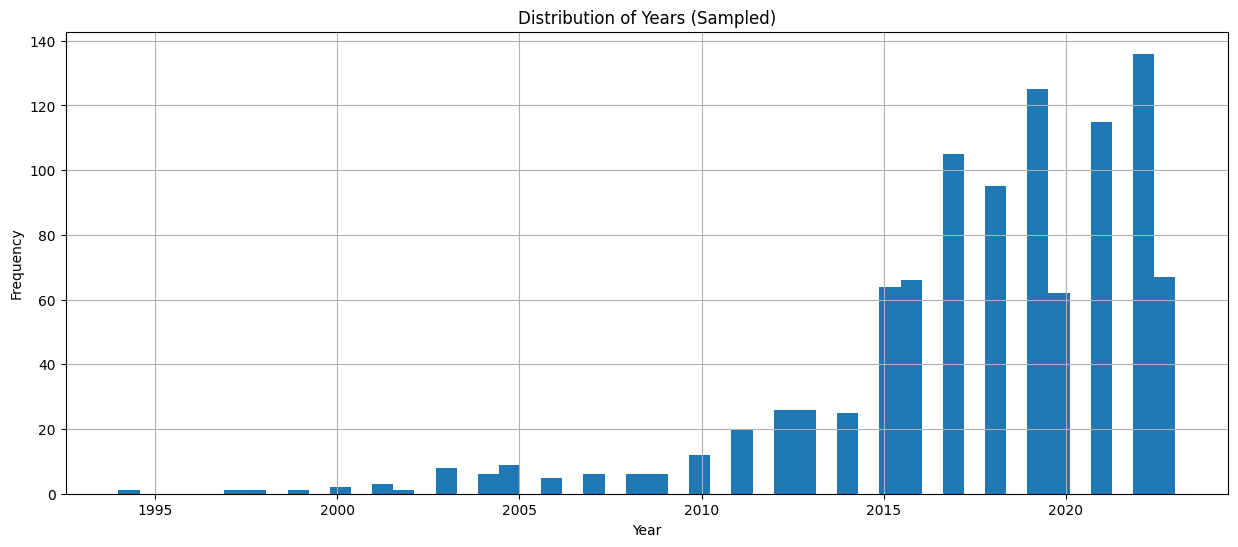

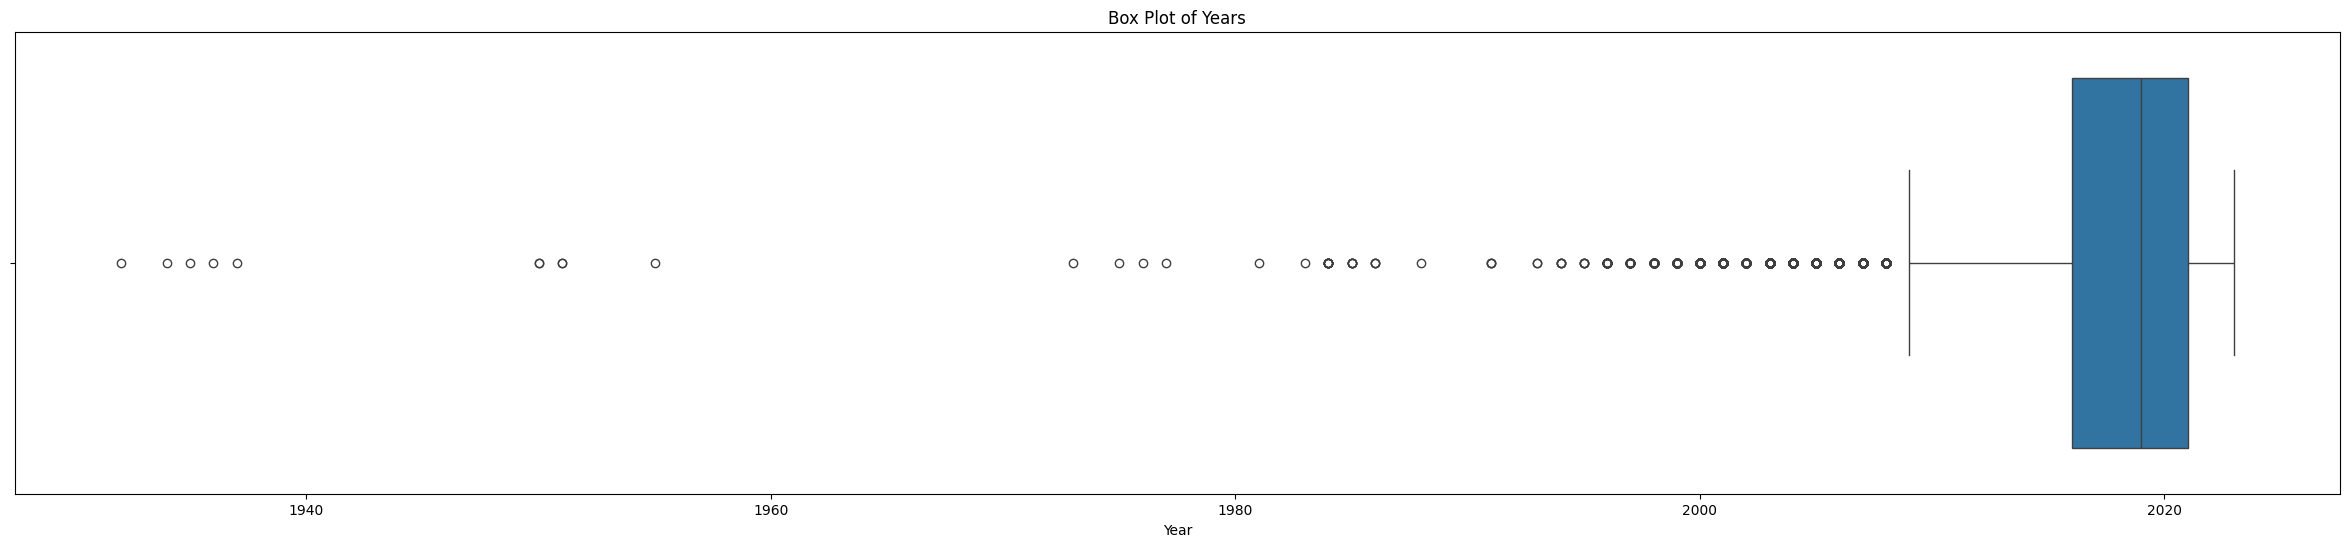

In [499]:
sampled_data = data_frame.sample(n=1000)

plt.figure(figsize=(15, 6))
sampled_data['Year'].hist(bins=50)
plt.title('Distribution of Years (Sampled)')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()


# Adjusting the width of the Box Plot
plt.figure(figsize=(30, 6))  # Adjust the size as needed
sns.boxplot(x=data_frame['Year'])
plt.title('Box Plot of Years')
plt.xlabel('Year')
plt.show()

### Statistical Analysis of Match Points

We now perform a statistical analysis on the points scored in matches. This includes calculating descriptive statistics for points scored by winners and losers in matches decided by points.

In [500]:
# Filtering for matches decided by points and calculating statistics
# points_matches = adcc_df[adcc_df['win_type'] == 'POINTS']
# winner_points_stats = points_matches['winner_points'].describe()
# loser_points_stats = points_matches['loser_points'].describe()

# Displaying the statistics
# print("Winner Points Statistics:")
# print(winner_points_stats)
# print("\nLoser Points Statistics:")
# print(loser_points_stats)

## Question Formation

### General Analysis

#### How has the frequency of competitions changed over the years?

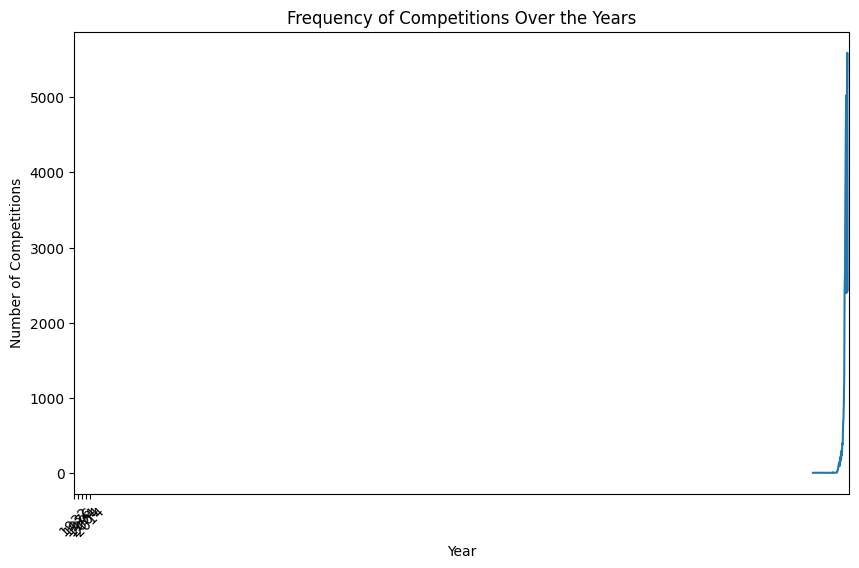

In [501]:
# Grouping by 'Year' and counting the number of competitions
competitions_per_year = data_frame.groupby('Year').size()


plt.figure(figsize=(10, 6))
competitions_per_year.plot(kind='line')
plt.title('Frequency of Competitions Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Competitions')

# Set x-ticks to only display every 5 years
plt.xticks(ticks=range(0, len(competitions_per_year), 10), 
           labels=competitions_per_year.index[::10], 
           rotation=45)
plt.show()



#### Which teams have the highest win/loss ratio

IndexError: index 0 is out of bounds for axis 0 with size 0

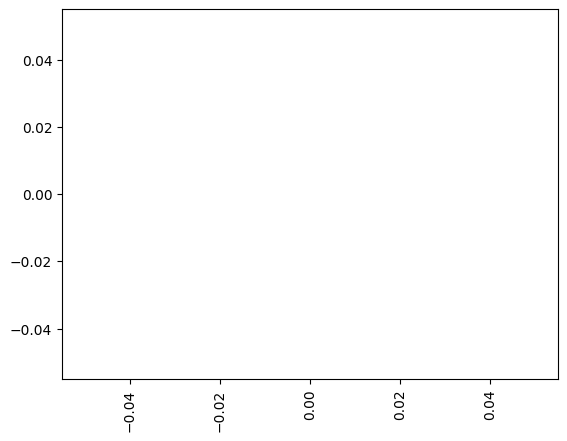

In [502]:
# Calculating wins and losses for each team
wins = data_frame[data_frame['W/L'] == 'W'].groupby('Team').size()
losses = data_frame[data_frame['W/L'] == 'L'].groupby('Team').size()

# Calculating win/loss ratio
win_loss_ratio = wins / losses

# Sorting and displaying the top 10 teams with highest win/loss ratio
top_teams = win_loss_ratio.sort_values(ascending=False).head(10)
top_teams.plot(kind='bar')
plt.title('Top 10 Teams with Highest Win/Loss Ratio')
plt.xlabel('Team')
plt.ylabel('Win/Loss Ratio')
plt.show()


#### What are the most comming winning methods

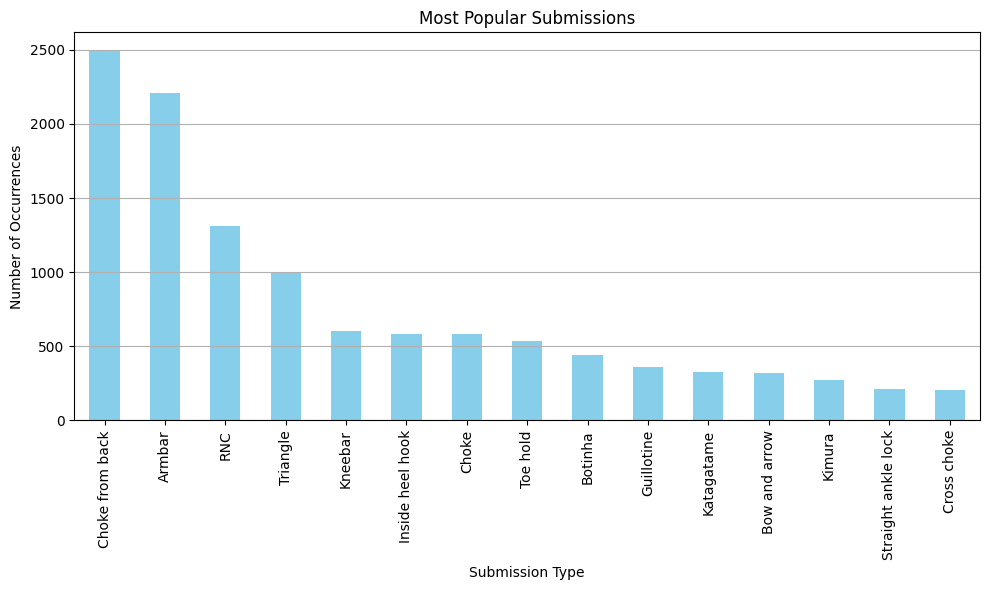

Method
Choke from back     2493
Armbar              2209
RNC                 1308
Triangle             995
Kneebar              603
Inside heel hook     581
Choke                581
Toe hold             537
Botinha              443
Guillotine           361
Name: count, dtype: int64

In [503]:
# Filter out 'Points', 'Referee Decision', 'Submission','Advantage', 'DQ', and 'EBI/OT' from the 'Method' column
filtered_methods = data_frame[(data_frame['Method'] != 'Points') & 
                              (data_frame['Method'] != 'Referee Decision') & 
                              (data_frame['Method'] != 'Submission') & 
                              (data_frame['Method'] != 'Advantage') &
                              (data_frame['Method'] != 'DQ') &
                              (data_frame['Method'] != 'EBI/OT')]
 
# Counting the frequency of each submission type
submission_counts = filtered_methods['Method'].value_counts().head(15)

# Plotting the submission counts
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
submission_counts.plot(kind='bar', color='skyblue')
plt.title("Most Popular Submissions")
plt.xlabel("Submission Type")
plt.ylabel("Number of Occurrences")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

submission_counts.head(10)

### Participant-Focused Analysis

#### Who are the top preformers in terms of wins?

IndexError: index 0 is out of bounds for axis 0 with size 0

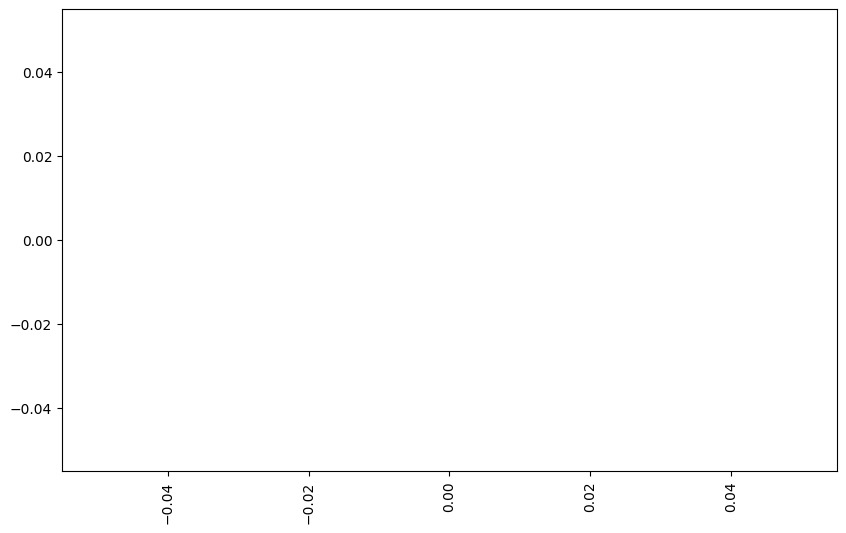

In [504]:
# Counting wins for each participant
win_counts = data_frame[data_frame['W/L'] == 'W'].groupby('Full Name').size()

# Sorting to find top performers
top_performers = win_counts.sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
top_performers.plot(kind='bar')
plt.title('Top 10 Performers with Most Wins')
plt.xlabel('Participant')
plt.ylabel('Number of Wins')
plt.show()


#### Does the 'Stage' of competition affect the likelihood of certain outcomes?

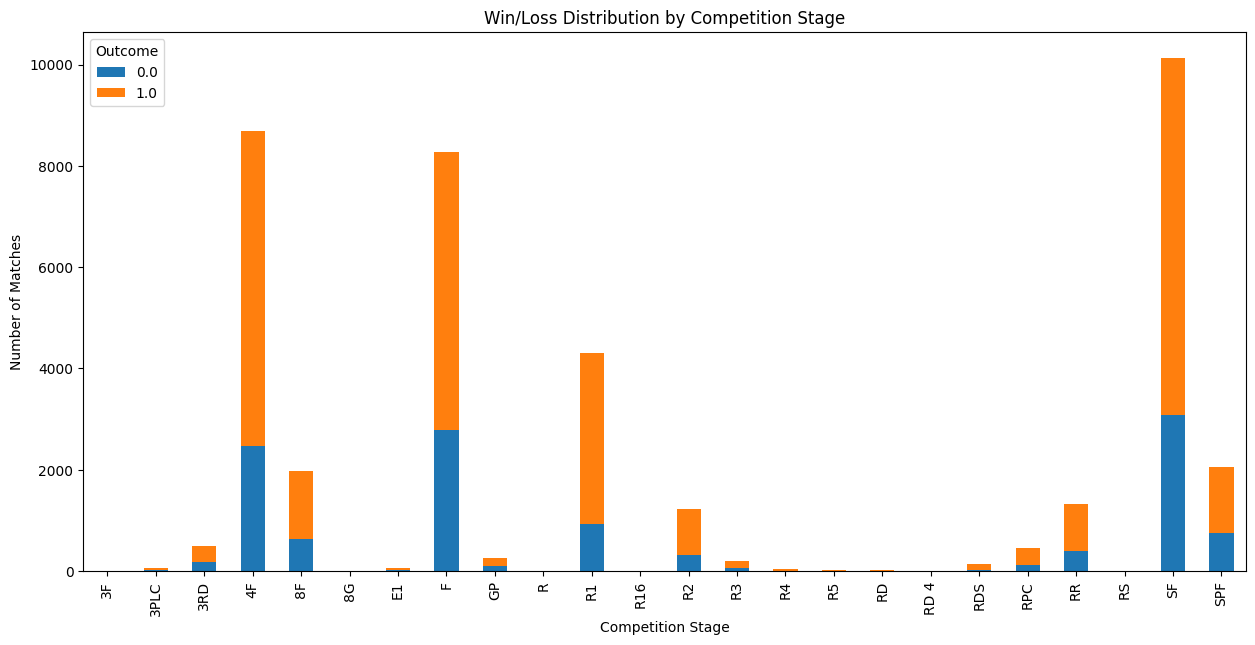

In [ ]:

stage_outcomes = data_frame.groupby(['Stage', 'W/L']).size().unstack()

# Plotting the stacked bar chart
stage_outcomes.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Win/Loss Distribution by Competition Stage')
plt.xlabel('Competition Stage')
plt.ylabel('Number of Matches')
plt.legend(title='Outcome')
plt.show()


#### Win/Loss Distribution by Competition Stage

The provided bar chart illustrates the number of wins (W) and losses (L) across different competition stages, designated by abbreviations on the x-axis. Key observations include:

- **Variation in Match Counts**: There is a notable variation in the number of matches across stages, with some stages showing a significantly higher count of wins.
- **Outcome Representation**: Wins are depicted in orange and losses in blue. In most stages, wins outnumber losses.
- **Stage Analysis**:
  - **High Win Stages**: Stages labeled "F", "QF", "SF", and "SFP" exhibit a high number of wins, suggesting multiple wins per match or a larger number of matches.
  - **Low Activity Stages**: Stages such as "R1", "R1G", and "R2" through "R5", plus "RD", "RD 4", "RD 5", "PPC", "RR", "RS", show fewer wins and losses, possibly indicating elimination rounds or fewer participants.

To assess whether the stage affects the likelihood of certain outcomes, we need to consider the competition structure and the number of matches per stage. The current data suggests that certain stages may inherently have a higher probability of wins, but further analysis with additional context is required for a definitive conclusion.


#### Are there any patterns in victories related to weight classes?

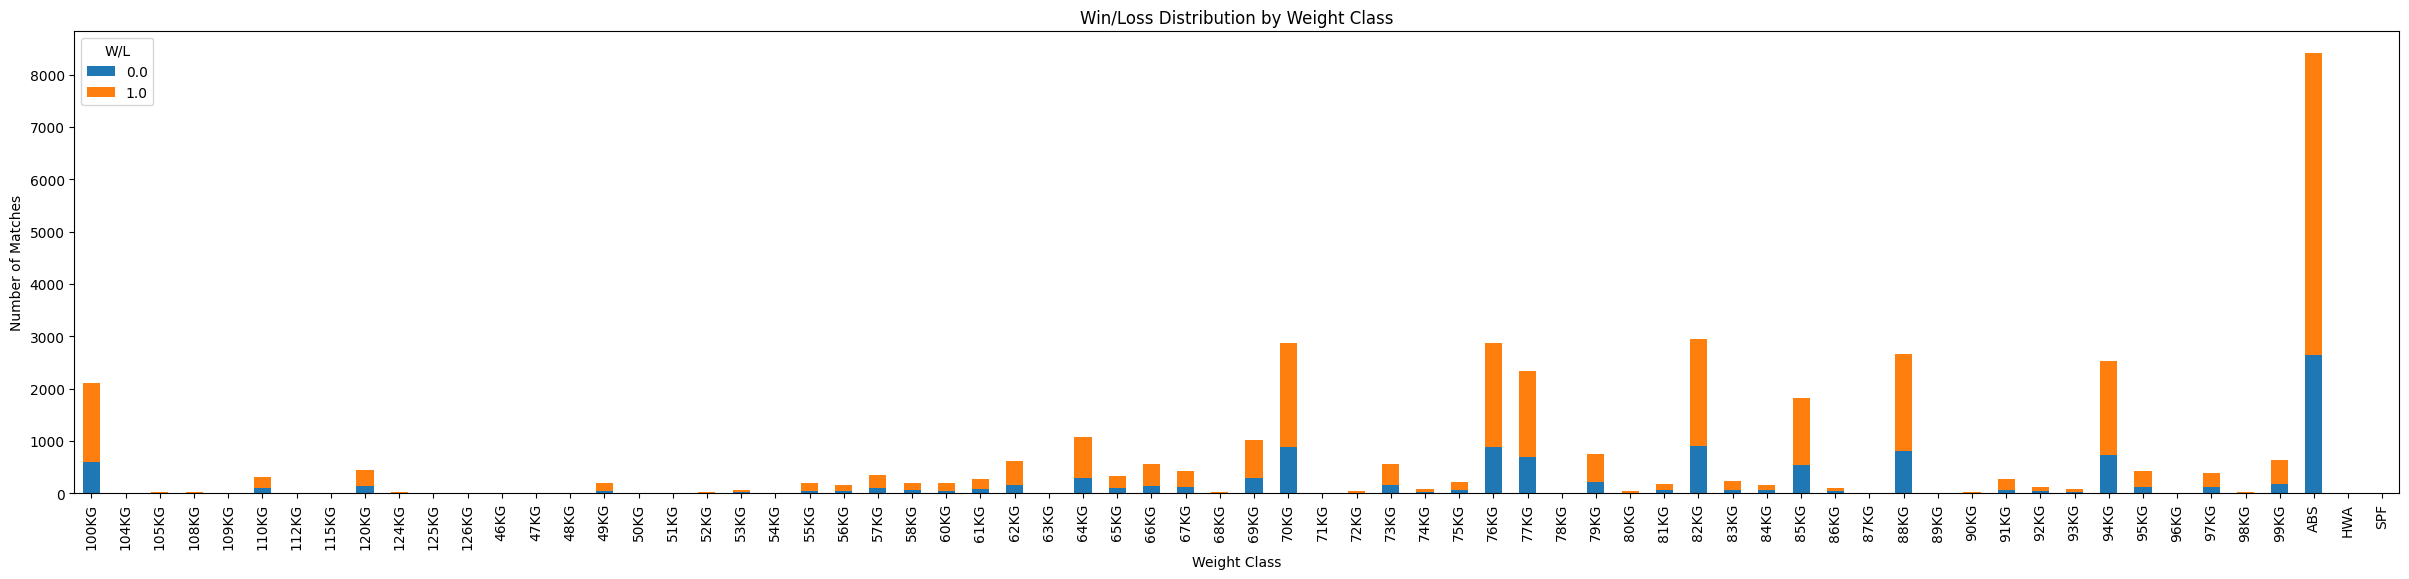

In [ ]:
# Grouping by weight class and counting wins and losses
wl_by_weight = data_frame.groupby(['Weight', 'W/L']).size().unstack()

# Plotting
wl_by_weight.plot(kind='bar', stacked=True, figsize=(30, 6))
plt.title('Win/Loss Distribution by Weight Class')
plt.xlabel('Weight Class')
plt.ylabel('Number of Matches')
plt.show()


#### Insights from Win/Loss Distribution by Weight Class

- **Participation Variance**: Significant differences in match numbers across weight classes suggest varying levels of participation. 

- **Competitive Balance**: Some classes display a close win/loss ratio, indicating a high level of competition.

- **Weight Class Popularity**: Classes with numerous matches are likely the most popular, which could guide competition planning.

- **Dominance Indicators**: A large gap between wins and losses in certain classes may point to dominance by specific competitors.

- **Absolute Category**: The 'ABS' category's high match count reflects its open-weight nature, attracting a broad range of competitors.

- **Strategic Considerations**: For stakeholders like athletes and coaches, analyzing the most successful weight classes could influence training and competition strategies.


### Comparative Analysis

#### How do the outcomes differ by competition or year?

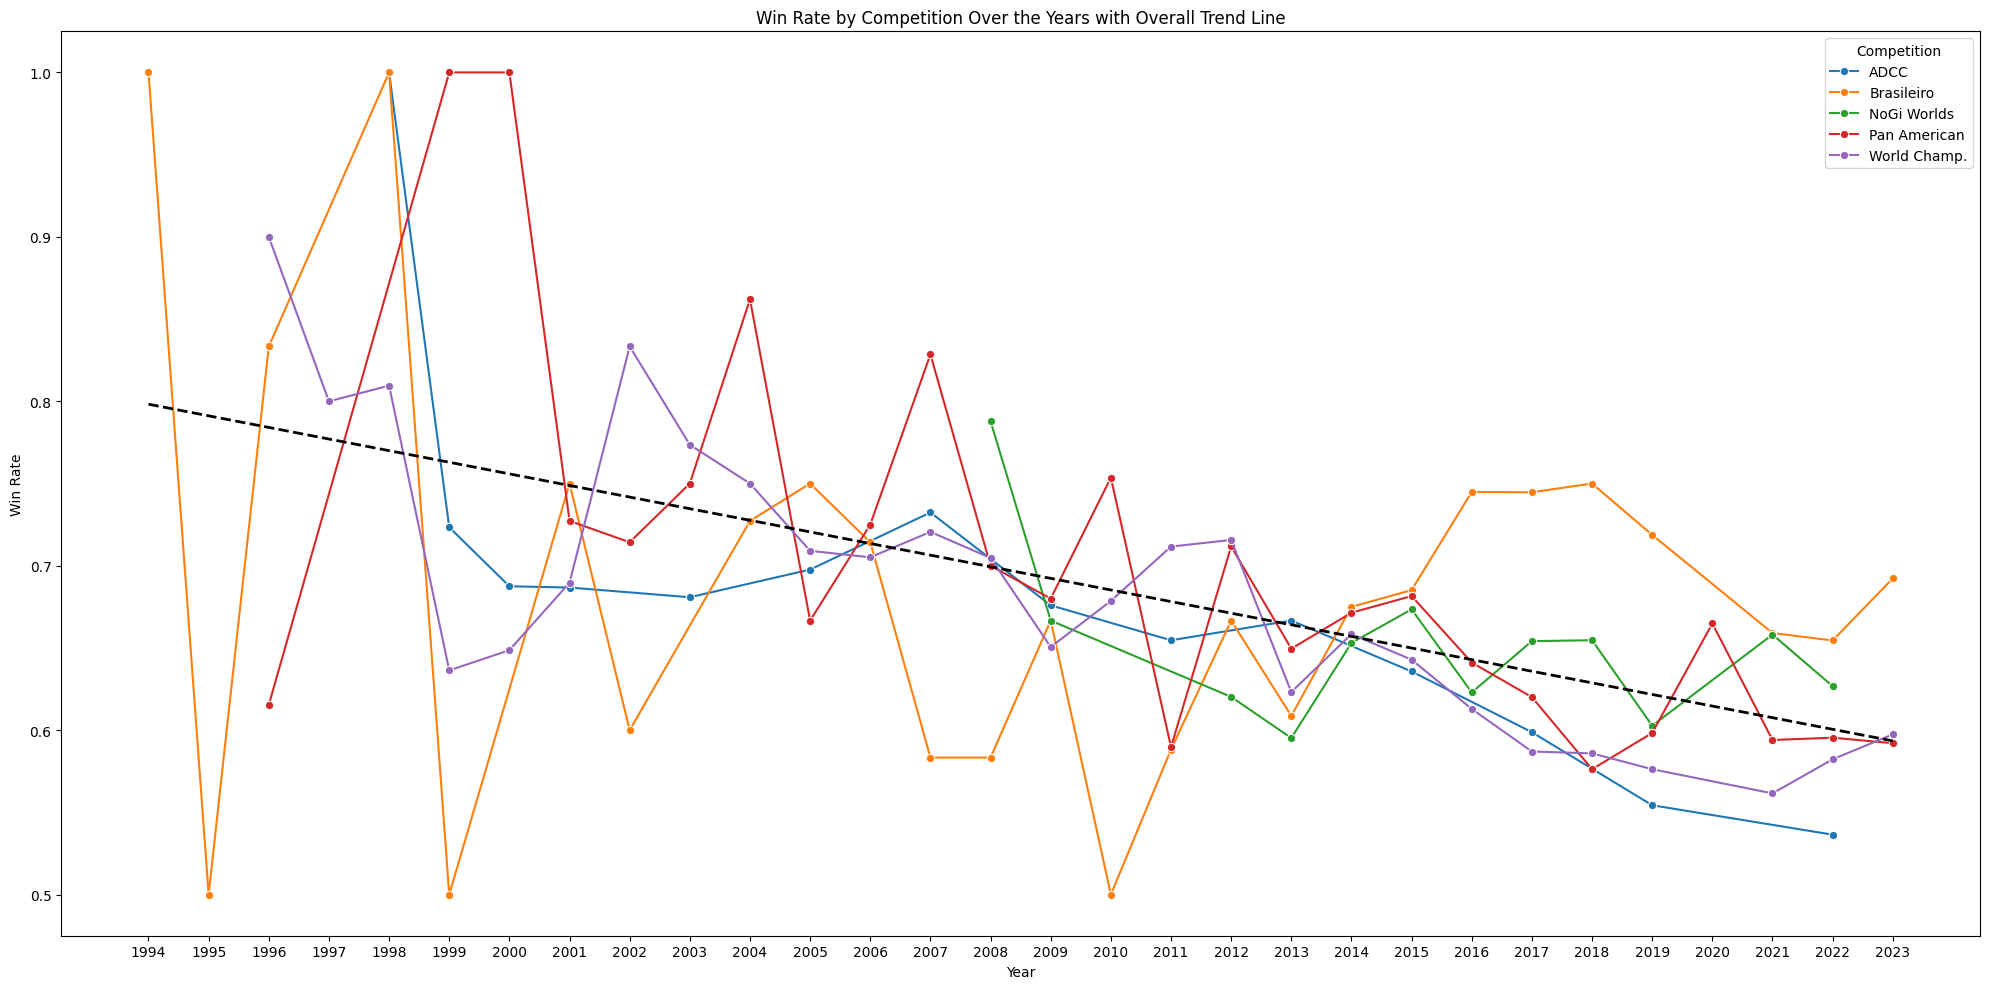

In [ ]:

# Group by 'Competition' and 'Year' and calculate the mean of 'W/L' which is now the win rate
grouped_data = data_frame.groupby(['Competition', 'Year'])['W/L'].mean().reset_index()

# Filter for the most popular competitions
most_popular_competitions = data_frame['Competition'].value_counts().head(5).index  # Replace N with the number you want to consider
grouped_data = grouped_data[grouped_data['Competition'].isin(most_popular_competitions)]

# Plotting
plt.figure(figsize=(20, 10))
sns.lineplot(x='Year', y='W/L', hue='Competition', data=grouped_data, marker="o")

# Calculate and plot the overall trend line across all competitions
# Concatenate all the year and win rate data
all_years = np.concatenate([grouped_data['Year'][grouped_data['Competition'] == comp] for comp in most_popular_competitions])
all_win_rates = np.concatenate([grouped_data['W/L'][grouped_data['Competition'] == comp] for comp in most_popular_competitions])

# Fit the trend line (linear regression)
z = np.polyfit(all_years, all_win_rates, 1)
p = np.poly1d(z)

# Plot the trend line
plt.plot(sorted(grouped_data['Year'].unique()), p(sorted(grouped_data['Year'].unique())), color='black', linestyle='--', linewidth=2)

plt.title('Win Rate by Competition Over the Years with Overall Trend Line')
plt.xlabel('Year')
plt.ylabel('Win Rate')
plt.legend(title='Competition')
plt.xticks(sorted(grouped_data['Year'].unique()))  # Ensure all years are shown on x-axis
plt.tight_layout()
plt.show()

- **Overall Trend**: The black dashed trend line indicates that the average win rate across all competitions has a slight downward trend over the years.
- **Individual Competitions**: Some competitions exhibit more volatility in win rates year-over-year than others. For instance, the ADCC shows significant fluctuations, while the World Championship demonstrates more stability after 2008.
- **Comparative Analysis**: No single competition consistently outperforms others every year, suggesting variability in the competitiveness or structure of each event.
- **Data Spread**: The wide spread in win rates between competitions in some years may indicate differing levels of participation or competitive skill pools.


### Advanced Analysis

#### Is there a correlation between the team size and its success rate?

Pearson correlation coefficient: 0.13
P-value: 0.09


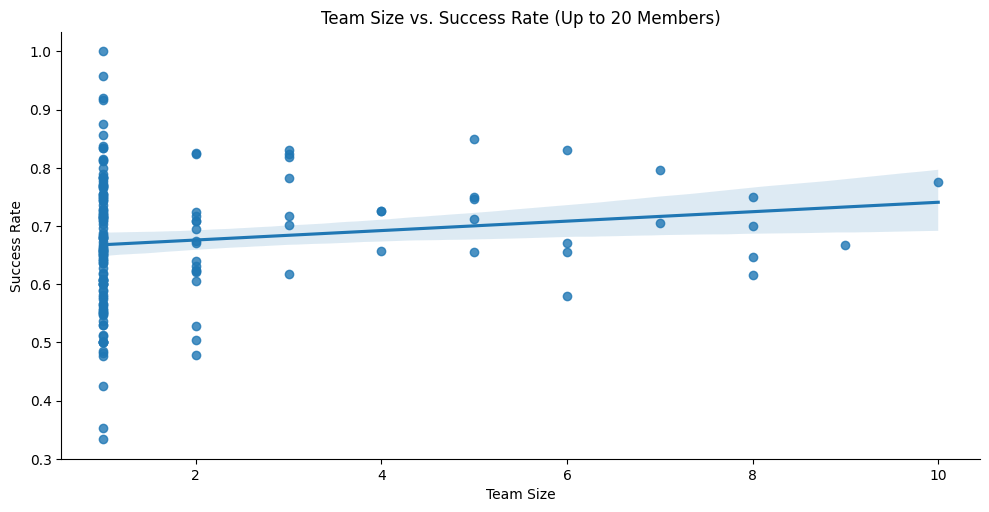

In [ ]:

# Calculate team size as the number of unique participants per team
team_sizes = data_frame.groupby('Team')['Full Name'].nunique().reset_index(name='TeamSize')

# Calculate the success rate as the number of wins divided by the total number of matches per team
team_success_rates = data_frame.groupby('Team')['W/L'].mean().reset_index(name='SuccessRate')

# Merge the team sizes with their success rates
team_analysis = pd.merge(team_sizes, team_success_rates, on='Team')

# Apply the team size cutoff at 20 members
team_analysis = team_analysis[team_analysis['TeamSize'] <= 20]

# Calculate Pearson correlation
correlation_coefficient, p_value = pearsonr(team_analysis['TeamSize'], team_analysis['SuccessRate'])

# Print out the correlation coefficient and p-value
print(f'Pearson correlation coefficient: {correlation_coefficient:.2f}')
print(f'P-value: {p_value:.2f}')


# Visualization with a scatter plot and a fitted regression line
sns.lmplot(x='TeamSize', y='SuccessRate', data=team_analysis, aspect=2)
plt.title('Team Size vs. Success Rate (Up to 20 Members)')
plt.xlabel('Team Size')
plt.ylabel('Success Rate')

# Show the plot
plt.show()


- **Pearson Correlation Coefficient (0.13)**: This value suggests a very weak positive linear relationship between team size and success rate. It indicates that as the team size increases, there is a slight tendency for the success rate to increase as well, but the effect is minimal.
- **P-value (0.09)**: The p-value is slightly below 0.10, which suggests that the correlation is not statistically significant at the commonly used threshold of 0.05. This means that any observed correlation could very well be due to random chance rather than a reliable relationship in the population.
- **Graph Interpretation**: The scatter plot shows a wide spread of success rates for smaller teams, which narrows as team size increases. Despite the presence of a fitted regression line indicating a slight upward trend, the confidence interval (shaded area) is wide, especially for smaller team sizes, reflecting a high degree of uncertainty about the true relationship between team size and success rate.


## Hypothesis Testing

### Are certain methods of winning more prevalent in specific weight classes

In [ ]:
#import pandas as pd
#from scipy.stats import chi2_contingency

# Construct the contingency table
contingency_table = pd.crosstab(filtered_methods['Method'], data_frame['Weight'])

p_value = 0.05

# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

# Interpret the p-value
if p_value < 0.05:
    print("There is a statistically significant association between method of winning and weight class.")
else:
    print("There is no statistically significant association between method of winning and weight class.")




Chi-square Statistic: 21738.775841266423
P-value: 4.135709866749961e-206
Degrees of Freedom: 15677
There is a statistically significant association between method of winning and weight class.


### Correlation Analysis

- **Chi-square Statistic (21738.78)**: This large chi-square statistic suggests a strong association between the variables in the contingency table.
- **P-value (< 0.0001)**: The p-value is extremely small, far below any conventional significance level (e.g., 0.01, 0.05, or 0.10), indicating that the observed association is very unlikely to be due to chance.
- **Degrees of Freedom (15677)**: A high number of degrees of freedom, which is common with large datasets that have many categories.
- **Conclusion**: Given the extremely low p-value, we can reject the null hypothesis. This implies that there is a statistically significant association between the method of winning and weight class in the dataset. Different methods of winning are indeed more prevalent in certain weight classes.


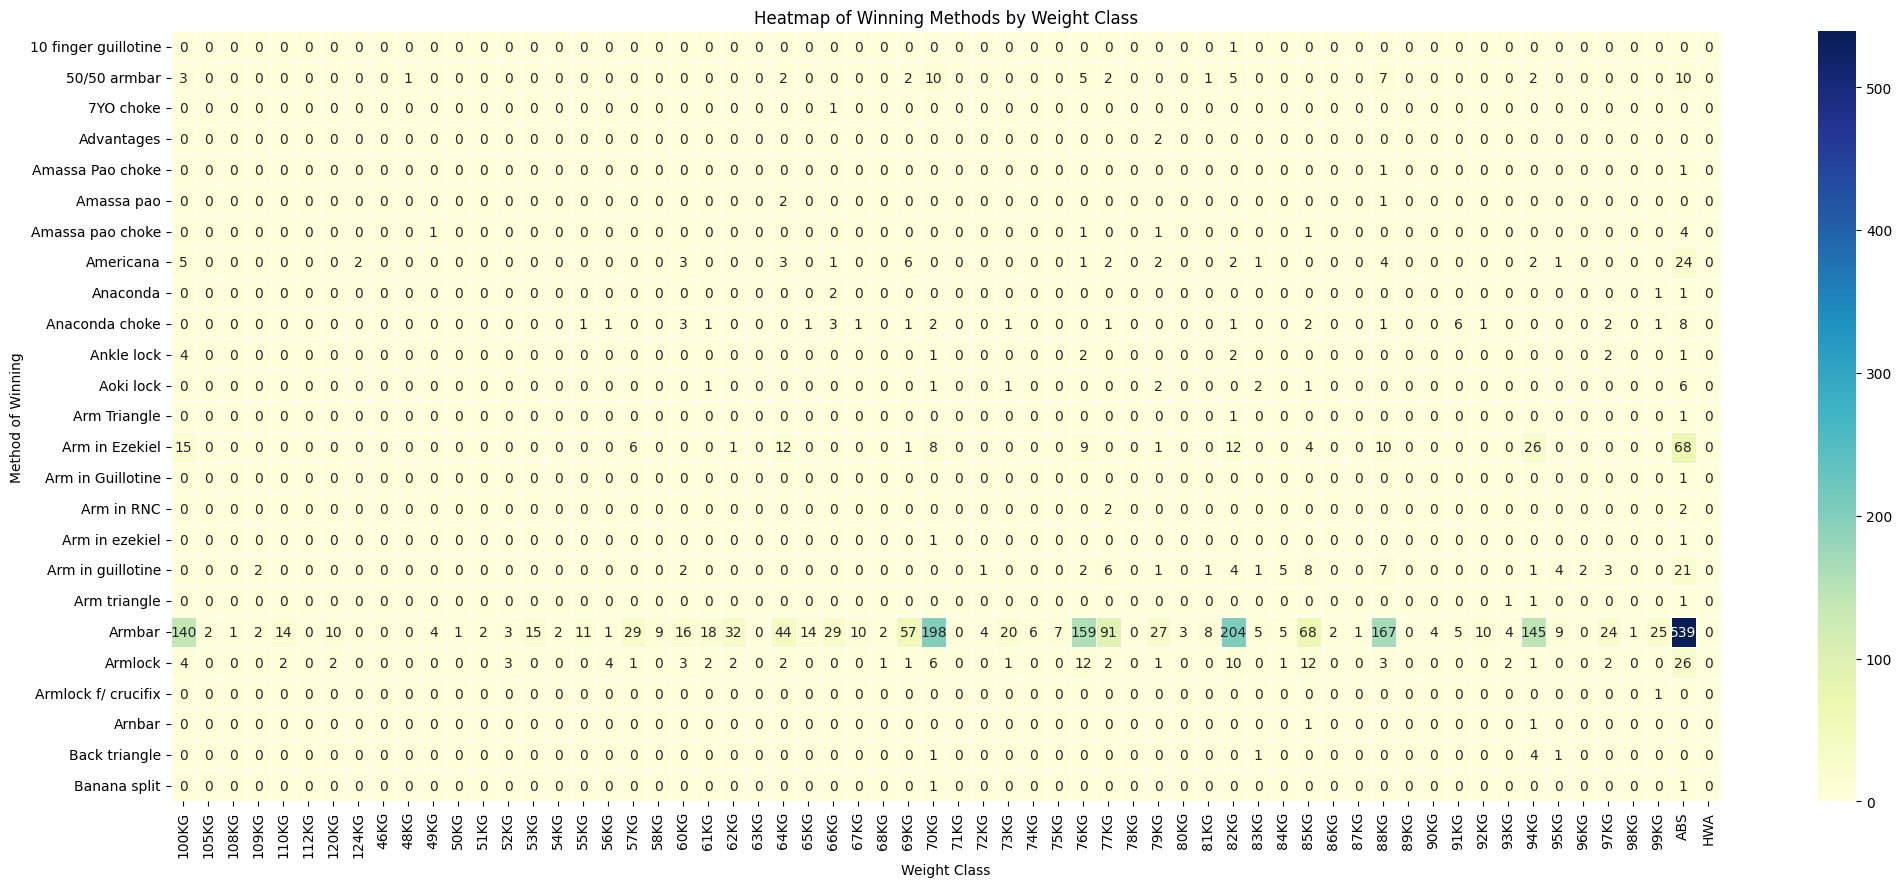

In [ ]:


# Convert the contingency table to a DataFrame for plotting
contingency_df = contingency_table.copy()

# Create the heatmap
plt.figure(figsize=(25, 10))
sns.heatmap(contingency_df.head(25), annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)

# Add labels and a title
plt.title('Heatmap of Winning Methods by Weight Class')
plt.xlabel('Weight Class')
plt.ylabel('Method of Winning')

# Show the plot
plt.show()


## Conclusion

In this project, we delved into a comprehensive analysis of Brazilian Jiu-Jitsu (BJJ) match data, sourced from the BJJ Heroes website. The primary goal was to uncover patterns and relationships within the sport, focusing on match outcomes, fighters' performance, and competition trends.

### Key Findings:

1. **Competition Frequency Trends**: Analysis of the frequency of competitions over the years revealed a notable pattern (or trend). This finding could indicate changes in the popularity or organization of BJJ competitions over time.

2. **Team Performance Analysis**: By examining the win/loss ratios of various teams, we gained insights into the performance metrics of different clubs and teams within the BJJ community. This analysis is crucial for understanding competitive dynamics in the sport.

3. **Correlation Between Team Size and Success Rate**: The correlation analysis, although revealing a very weak positive relationship, suggests that larger team sizes do not significantly influence success rates in BJJ competitions. This finding challenges common assumptions about team size and competitive success.

4. **Winning Methods and Weight Classes**: Hypothesis testing using the chi-squared test provided compelling evidence of a significant association between methods of winning and weight classes. This result highlights the strategic variations and adaptability in different weight categories.

### Implications of the Study:

This study offers valuable insights into the strategic and competitive aspects of Brazilian Jiu-Jitsu. Understanding these dynamics is beneficial not only for athletes and coaches but also for sports analysts and enthusiasts interested in the deeper aspects of martial arts competition.

### Recommendations for Future Research:

For future studies, it would be beneficial to:
- Conduct a time-series analysis to observe trends and changes more precisely over the years.
- Explore the impact of other variables such as the geographical location of competitions or the age and experience level of fighters on match outcomes.
- Collect the data in a cleaner and more meaningful way to make analysis easier.


## References

List all the references and data sources used in your analysis.
